# Cubicasa Dataset Converter

This is the conversion of the Cubicasa dataset into an images(.png) + labels(.npy) format, to make it easier to combine with other datasets and train a vision model.

## References
https://github.com/CubiCasa/CubiCasa5k

## Step 1
- Create a folder called "data" or a symlink to a dataset folder you want to store it in

## Step 2
- Import libraries

In [6]:
import os
import time
import math
import numpy as np
from numpy import genfromtxt

from xml.dom import minidom

from skimage.draw import polygon
import skimage.measure as skm

from svgpathtools import parse_path

from logging import warning

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pickle

from random import randint

from loaders.house import House, icons_selected, rooms_selected, icon_name_map, room_name_map
from loaders.svg_loader import FloorplanSVG

from torch.utils.data import Dataset
import pickle
import torch
import lmdb
import cv2

import matplotlib.patches as patches
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from pycocotools import mask as coco_mask

## Step 3: Set Directories and Variables
- If you want to compile the Cubicasa dataset yourself, you can use the following below.
- Modify the directories to suit the folder structure you have though.

In [17]:
CUBICASA_DIR = "./cubicasa5k"
DATA_DIR = './data/Cubicasa/compiled/'
ORIGINAL_CUBICASA_FOLDER = "high_quality"
PROCESSED_DATA_DIR = './data/detectron_training_data/'
DATA_FILE = 'compiled.txt'
DATA_REF_FILE = "./data/Cubicasa/debug.txt"
CLASSES = ['Wall', 'Window', 'Door']

### Preprocess to compile cubicasa dataset to a single folder

In [11]:
# Define the output file path
output_file = os.path.join(CUBICASA_DIR, DATA_FILE)

# Get the list of folders in DATA_DIR
folders = os.listdir(DATA_DIR)

# Open the output file in write mode
with open(output_file, 'w') as f:
    for folder in folders:
        # Construct the path format for each folder
        line = f"compiled/{folder}/\n"
        f.write(line)

print(f"Total folders processed: {len(folders)}")
print(f"Output written to {output_file}")

Total folders processed: 5000
Output written to ./data/Cubicasa/compiled_train.txt


## Modified Floorplan SVG Dataset Class

### Modified class

In [12]:
# class FloorplanSVG(Dataset):
#     def __init__(self, data_folder, data_file, is_transform=True,
#                  augmentations=None, img_norm=True, format='txt',
#                  original_size=False, lmdb_folder='cubi_lmdb/', icons_selected=icons_selected, rooms_selected=rooms_selected):
        
#         self.img_norm = img_norm
#         self.is_transform = is_transform
#         self.augmentations = augmentations
#         self.get_data = None
#         self.original_size = original_size
#         self.image_file_name = '/F1_scaled.png'
#         self.org_image_file_name = '/F1_original.png'
#         self.svg_file_name = '/model.svg'
#         self.icons_selected = icons_selected
#         self.rooms_selected = rooms_selected

#         if format == 'txt':
#             self.get_data = self.get_txt
#         if format == 'lmdb':
#             self.lmdb = lmdb.open(data_folder+lmdb_folder, readonly=True,
#                                   max_readers=8, lock=False,
#                                   readahead=True, meminit=False)
#             self.get_data = self.get_lmdb
#             self.is_transform = False

#         self.data_folder = data_folder
#         # Load txt file to list
#         self.folders = genfromtxt(data_folder + data_file, dtype='str')

#     def __len__(self):
#         """__len__"""
#         return len(self.folders)

#     def __getitem__(self, index):
#         sample = self.get_data(index)

#         if self.augmentations is not None:
#             sample = self.augmentations(sample)
            
#         if self.is_transform:
#             sample = self.transform(sample)

#         return sample

#     def get_house(self, index):
#         fplan = cv2.imread(self.data_folder + self.folders[index] + self.image_file_name)
#         fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
#         height, width, nchannel = fplan.shape
        
#         # Getting labels for segmentation and heatmaps
#         if self.icons_selected and self.rooms_selected:
#             house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width, self.icons_selected, self.rooms_selected)
#         elif self.icons_selected and not self.rooms_selected:
#             house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width, self.icons_selected)
#         elif not self.icons_selected and not self.rooms_selected:
#             house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width)
#         return house
        
#     def get_txt(self, index):
#         # print(f"Getting data from {self.data_folder + self.folders[index]}")
#         fplan = cv2.imread(self.data_folder + self.folders[index] + self.image_file_name)
#         fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
#         height, width, nchannel = fplan.shape
#         fplan = np.moveaxis(fplan, -1, 0)

#         # Getting labels for segmentation and heatmaps
#         if self.icons_selected and self.rooms_selected:
#             house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width, self.icons_selected, self.rooms_selected)
#         elif self.icons_selected and not self.rooms_selected:
#             house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width, self.icons_selected)
#         elif not self.icons_selected and not self.rooms_selected:
#             house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width)
            
#         # Combining them to one numpy tensor
#         label = torch.tensor(house.get_segmentation_tensor().astype(np.float32))
#         heatmaps = house.get_heatmap_dict()
#         coef_width = 1
#         if self.original_size:
#             fplan = cv2.imread(self.data_folder + self.folders[index] + self.org_image_file_name)
#             fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
#             height_org, width_org, nchannel = fplan.shape
#             fplan = np.moveaxis(fplan, -1, 0)
#             label = label.unsqueeze(0)
#             label = torch.nn.functional.interpolate(label,
#                                                     size=(height_org, width_org),
#                                                     mode='nearest')
#             label = label.squeeze(0)

#             coef_height = float(height_org) / float(height)
#             coef_width = float(width_org) / float(width)
#             for key, value in heatmaps.items():
#                 heatmaps[key] = [(int(round(x*coef_width)), int(round(y*coef_height))) for x, y in value]

#         img = torch.tensor(fplan.astype(np.float32))

#         sample = {'image': img, 'label': label, 'folder': self.folders[index],
#                   'heatmaps': heatmaps, 'scale': coef_width}

#         return sample

#     def get_lmdb(self, index):
#         key = self.folders[index].encode()
#         with self.lmdb.begin(write=False) as f:
#             data = f.get(key)

#         sample = pickle.loads(data)
#         return sample

#     def transform(self, sample):
#         fplan = sample['image']
#         # Normalization values to range -1 and 1
#         fplan = 2 * (fplan / 255.0) - 1

#         sample['image'] = fplan

#         return sample

### Initialise dataset

In [13]:
# Initialize the dataset
dataset = FloorplanSVG(
    data_folder=CUBICASA_DIR,
    data_file=DATA_FILE,
    is_transform=True,       # Whether to apply transformations
    augmentations=None,      # Provide any augmentations (e.g., from albumentations)
    img_norm=True,           # Normalize image to range [-1, 1]
    format='txt',            # Dataset format ('txt' or 'lmdb')
    original_size=False,     # Whether to use original image sizes
)

### Sampling from dataset

In [14]:
# Check if the dataset is not empty
if len(dataset) == 0:
    raise ValueError("The dataset is empty. Please check the data paths and files.")

print (f"Train Dataset size: {len(dataset)}")
# Retrieve random sample from the dataset
sample_index = randint(0, len(dataset) - 1)  # Change this index to view different samples
sample = dataset[sample_index]

Train Dataset size: 5000


In [15]:

sample['folder']

np.str_('compiled/3898/')

## Preprocess to convert Cubicasa dataset for training

In [10]:
room_mapping = {"Background": 0}  # Explicitly set Background to 0
idx = 1  # Start indexing from 1

for i in room_name_map:
    generalised_class = room_name_map[i]
    if generalised_class not in room_mapping:
        room_mapping[generalised_class] = idx
        idx += 1

icon_mapping = {}
for i in icon_name_map:
    generalised_class = icon_name_map[i]
    if generalised_class not in icon_mapping:
        icon_mapping[generalised_class] = idx
        idx += 1

combined_mapping = {
    "room_mapping":room_mapping,
    "icon_mapping":icon_mapping
}
print(combined_mapping)

{'room_mapping': {'Background': 0, 'Room': 1, 'Bath': 2, 'Bedroom': 3, 'Garage': 4, 'Storage': 5, 'Dining': 6, 'Entry': 7, 'Kitchen': 8, 'LivingRoom': 9, 'Outdoor': 10, 'Wall': 11, 'Railing': 12}, 'icon_mapping': {'Window': 13, 'Door': 14, 'Closet': 15, 'ElectricalAppliance': 16, 'Toilet': 17, 'Sink': 18, 'SaunaBench': 19, 'Fireplace': 20, 'Bathtub': 21, 'Chimney': 22, None: 23, 'None': 24}}


In [11]:
def preprocess_dataset(dataset, rooms_selected, icons_selected, mapping, img_output_dir="./data/detectron_training_data/images", npy_output_dir="./data/detectron_training_data/labels"):
    """
    Reassigns unique indices to each class across rooms_selected and icons_selected dictionaries to avoid conflicts,
    and saves visualizations of the reindexed classes as images and npy files.

    Parameters:
    - rooms_selected (dict): Dictionary mapping room class names to current labels.
    - icons_selected (dict): Dictionary mapping icon class names to current labels.
    - output_dir (str): Directory where the reindexed class images and npy files will be saved.

    Returns:
    - new_rooms_selected (dict): Dictionary with unique indices assigned to room classes.
    - new_icons_selected (dict): Dictionary with unique indices assigned to icon classes.
    """
    st = time.time()
    # Create the output directory if it doesn't exist
    os.makedirs(img_output_dir, exist_ok=True)
    os.makedirs(npy_output_dir, exist_ok=True)

    # processed_imgs = os.listdir(img_output_dir)
    processed_imgs = sorted([int(f.split('.')[0]) for f in os.listdir(img_output_dir) if f.endswith(".png")])
    start_idx = max(processed_imgs) + 1 if processed_imgs else 0
    print (f"Starting from image {start_idx}")
    # start_idx = 0
    debug_count = 0

    # Loop starting from start_idx
    for idx in range(start_idx, len(dataset)):
        sample = dataset[idx]  # Access the dataset at the given index

        # if debug_count > 0:
        #     break

        if (f"{idx}.png" in processed_imgs):
            print (f"Image already processed. Skipping {idx}.")
            # debug_count += 1
            continue

        # Save the image
        image = sample['image'].numpy()  # Shape: (C, H, W)
        image_filename = os.path.join(img_output_dir, f"{idx}.png")

        # Convert the image from (C, H, W) to (H, W, C) and normalize to [0, 255]
        image = np.transpose(image, (1, 2, 0))
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)

        # Process and save the label
        label = sample['label'].numpy()  # Shape: (channels, H, W)

        # Sanitize labels by replacing invalid values (e.g., 255) with 0
        label[label == 255] = 0

        reindexed_label = np.zeros_like(label, dtype=np.int64)

        # Map the labels for room classes (channel 0)
        for class_name, original_index in rooms_selected.items():
            mask = label[0] == original_index
            generalised_class = room_name_map[class_name]
            new_index = mapping['room_mapping'][generalised_class]
            reindexed_label[0] += mask * new_index

            # DEBUGGING STUFF
            # print (class_name)
            # print (generalised_class)
            # print (new_index)
            # print("----------------")

            # # Debug: Print mapping information
            # if np.any(mask):
            #     print(f"Mapped Room Class '{class_name}' (Original Index: {original_index}) to New Index: {new_index}")

        # Map the labels for icon classes (channel 1)
        for class_name, original_index in icons_selected.items():
            mask = label[1] == original_index
            generalised_class = icon_name_map[class_name]
            new_index = mapping['icon_mapping'][generalised_class]
            reindexed_label[1] += mask * new_index

            # DEBUGGING STUFF
            # print (class_name)
            # print (generalised_class)
            # print (new_index)
            # print("----------------")
            
        # Convert the reindexed label back to uint8 for saving
        reindexed_label = np.clip(reindexed_label, 0, 255).astype(np.uint8)

        label_filename = os.path.join(npy_output_dir, f"{idx}.npy")

        plt.imsave(image_filename, image)
        np.save(label_filename, reindexed_label)

        # # Create and save the visualization for "Wall" class, to make sure we are saving the data properly.
        # wall_visualization = np.zeros((label.shape[1], label.shape[2], 3), dtype=np.uint8)
        # wall_mask = reindexed_label == new_mapping["Wall"]  # Use the reindexed label for "Wall"
        # wall_visualization[wall_mask] = [255, 0, 0]  # Red color for "Wall"
        # wall_visualization_filename = os.path.join(img_output_dir, f"{idx}_wall.png")
        # plt.imsave(wall_visualization_filename, wall_visualization)

        debug_count += 1
        
    et = time.time()
    print (f"Saved a total of {debug_count} samples in {et-st} seconds")

In [12]:
preprocess_dataset(dataset, rooms_selected=rooms_selected, icons_selected=icons_selected, mapping=combined_mapping)
# print (new_room_dict)
# print (new_icons_dict)

In [12]:
def visualize_sample(image_path, npy_path, classes, mapping):
    """
    Visualizes the image, the npy masks, and an overlay of the npy masks on the image.

    Parameters:
    - image_path (str): Path to the saved image file.
    - npy_path (str): Path to the saved npy file containing the reindexed masks.
    - classes (list of str): List of class names corresponding to the indices in the masks.
    - mapping (dict): Mapping of room class names to indexed label values.

    Returns:
    - None
    """

    # Generate random colors for each class
    class_colors = {class_name: [randint(0, 255) for _ in range(3)] for class_name in classes}

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load the npy file
    masks = np.load(npy_path)  # Shape: (C, H, W)

    # Create an overlay with the same dimensions as the image
    overlay = np.zeros_like(image, dtype=np.uint8)

    # Iterate over each class to create masks and overlay
    for class_name in classes:
        label_val = 0

        if class_name in mapping['room_mapping']:
            channel = 0
            label_val = mapping['room_mapping'][class_name]

        elif class_name in mapping['icon_mapping']:
            channel = 1
            label_val = mapping['icon_mapping'][class_name]

        # Create a binary mask where the label matches
        mask = (masks[channel] == label_val).astype(np.uint8)

        # Debug: Ensure "Door" class has a valid mask
        if class_name == "Door":
            print(f"Debug: {class_name} {label_val} mask has {np.sum(mask)} active pixels.")

        # Assign the color for the class
        color = class_colors[class_name]

        # Apply the color to the overlay
        for c in range(3):
            overlay[:, :, c] += mask * color[c]

    # Blend the overlay with the original image
    blended = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)

    # Plot the original image, masks, and overlay
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # 2. Masks with Class Names
    axes[1].imshow(overlay)
    axes[1].set_title("Masks")
    for idx, class_name in enumerate(classes):
        color = class_colors[class_name]
        axes[1].text(10, 30 + idx * 20, f"{class_name}", color=np.array(color) / 255.0, fontsize=12, backgroundcolor="black")
    axes[1].axis("off")

    # 3. Overlay
    axes[2].imshow(blended)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

Debug: Door 14 mask has 5950 active pixels.


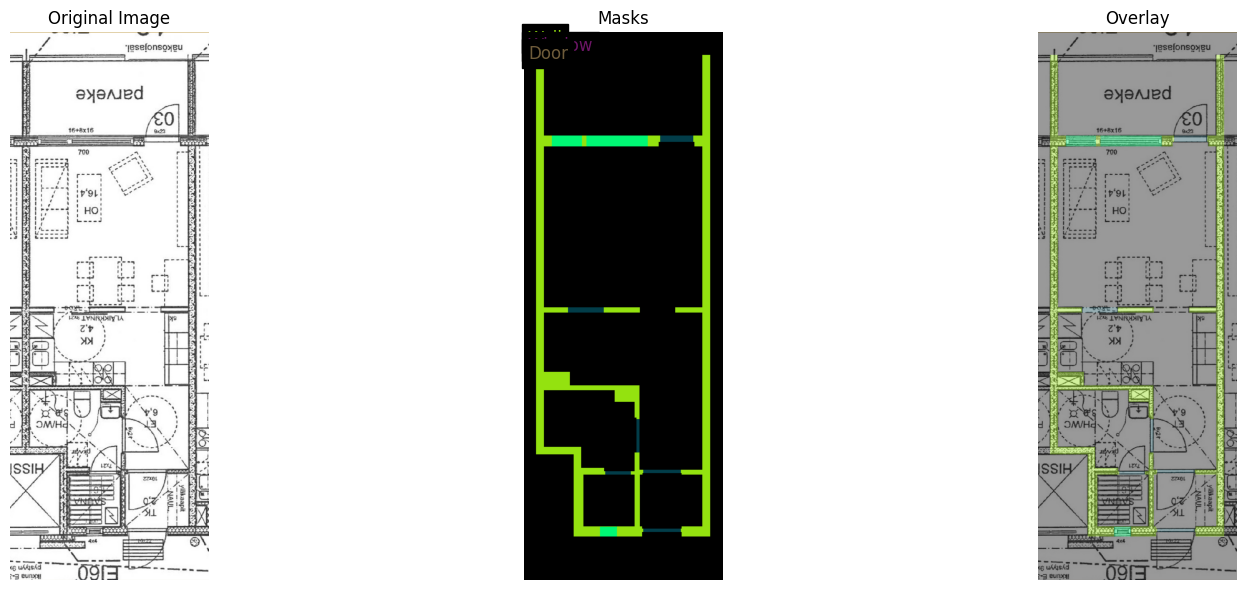

In [13]:
random_idx = randint(0, 500)
# random_idx = 0
# visualize_sample(f"./data/detectron_training_data/images/{random_idx}.png", f"./data/detectron_training_data/labels/{random_idx}.npy", CLASSES, room_mapping=room_mapping, icon_mapping=icons_mapping)
visualize_sample(f"./data/detectron_training_data/images/{random_idx}.png", f"./data/detectron_training_data/labels/{random_idx}.npy", CLASSES, mapping=combined_mapping)